In [696]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import autograd

SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


# Data

In [712]:
def generate_gauss_2d_dataset(mu, sigma, n_samples):
    samples = np.random.normal(
        loc=mu, scale=sigma, size=(n_samples, 2)).astype(np.float32)
    return samples


def generate_swissroll(scale, noise, n_samples):
    samples, _ = sklearn.datasets.make_swiss_roll(
        n_samples, noise=noise, random_state=SEED)
    return samples[:, (0, 2)].astype(np.float32)*scale


def std_scale(data, mu, std):
    return (data - mu)/std


def std_scale_inv(data, mu, std):
    return data*std + mu


class GaussDataset(Dataset):
    def __init__(self, mu=0, sigma=1, n_samples=1000, sample_scaled=False):
        super().__init__()
        self.data = torch.from_numpy(
            generate_gauss_2d_dataset(mu, sigma, n_samples)).to(DEVICE)

        self.mu = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)

        self.sample_scaled = sample_scaled

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def sample(self, n):
        sample = torch.stack(
            list(self.data[np.random.randint(low=0, high=len(self.data))]
                 for _ in range(n))
        )
        if self.sample_scaled:
            sample = std_scale(sample, self.mu, self.std)
        return sample


class SwissrollDataset(Dataset):
    def __init__(self, scale=1, noise=0.75, n_samples=1000, sample_scaled=False):
        super().__init__()
        self.data = torch.from_numpy(generate_swissroll(
            scale, noise, n_samples)).to(DEVICE)

        self.mu = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)

        self.sample_scaled = sample_scaled

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def sample(self, n):
        sample = torch.stack(
            list(self.data[np.random.randint(low=0, high=len(self.data))]
                 for _ in range(n)))
        if self.sample_scaled:
            sample = std_scale(sample, self.mu, self.std)
        return sample

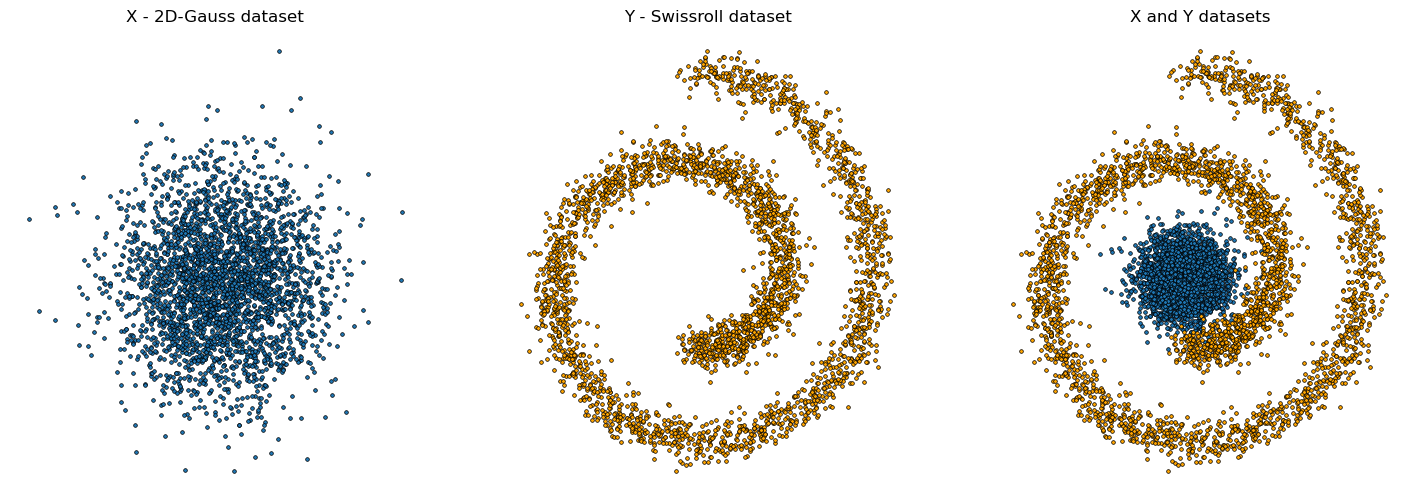

In [713]:
dataset_x = GaussDataset(n_samples=3000, sigma=1.5)
dataset_y = SwissrollDataset(n_samples=3000)

_, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(dataset_x.data[:, 0].cpu(),
               dataset_x.data[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[0].set_title("X - 2D-Gauss dataset")
axs[0].axis('off')

axs[1].scatter(dataset_y.data[:, 0].cpu(), dataset_y.data[:,
               1].cpu(), c='orange', s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[1].set_title("Y - Swissroll dataset")
axs[1].axis('off')

axs[2].scatter(dataset_x.data[:, 0].cpu(),
               dataset_x.data[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[2].scatter(dataset_y.data[:, 0].cpu(), dataset_y.data[:,
               1].cpu(), c='orange', s=7, marker='o', edgecolors='black', linewidths=0.5)
axs[2].set_title("X and Y datasets")
axs[2].axis('off')

plt.show()

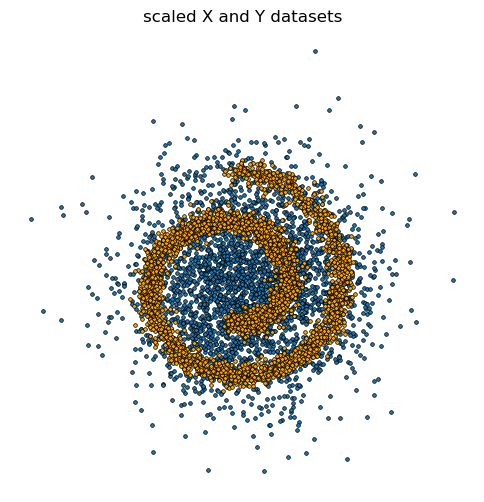

In [714]:
# scaled version preview
plt.figure(figsize=(6, 6))

scaled_ds_x = std_scale(dataset_x.data, dataset_x.mu, dataset_x.std)

scaled_ds_y = std_scale(dataset_y.data, dataset_y.mu, dataset_y.std)

plt.scatter(scaled_ds_x[:, 0].cpu(), scaled_ds_x[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
plt.scatter(scaled_ds_y[:, 0].cpu(), scaled_ds_y[:,
            1].cpu(), c='orange', s=7, marker='o', edgecolors='black', linewidths=0.5)
plt.title("scaled X and Y datasets")
plt.axis('off')

plt.show()

# Models and training

In [759]:
N_SAMPLES = 1024
EPS = 1.

N_STEPS=150
STEP_SIZE=1.5
SAMPLING_NOISE=8e-2

ALPHA = 1e-2

SCALED_REGIME = True
dataset_x.sample_scaled = SCALED_REGIME
dataset_y.sample_scaled = SCALED_REGIME

In [760]:
class BasicMLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.mlp(x)


class BasicModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.mlp = BasicMLP(hidden_dim)

    def forward(self, x):
        return self.mlp(x)


def c(x, y):
    """Wasserstein-2 distance"""
    return 0.5*torch.pow(torch.norm(x - y), 2)


def function_grad(f_out, arg, *args):
    """function gradient w.r.t input argumnets (support for batch-dim)"""
    grad = autograd.grad(
        outputs=f_out,
        inputs=arg,
        grad_outputs=torch.ones_like(f_out),
        create_graph=True,
        retain_graph=True
    )[0]
    return grad


def sample_from_joint_pi_theta(u_model, v_model, x_sample, y_sample, step_size=STEP_SIZE, num_steps=N_STEPS, sampling_noise=SAMPLING_NOISE, decay=1.):
    u_model.eval()
    v_model.eval()

    noise = step_size**0.5
    x, y = torch.normal(0, 3., size=x_sample.shape, device=DEVICE), torch.normal(
        0, 3., size=y_sample.shape, device=DEVICE)
    for _ in range(num_steps):
        with torch.enable_grad():
            x.requires_grad_(True)
            y.requires_grad_(True)
            
            x_potent = u_model(x)
            y_potent = v_model(y)
            
            plan_cost = c(x, y)

            energy_grad_x = function_grad(x_potent, x) - function_grad(plan_cost, x)
            energy_grad_y = function_grad(y_potent, y) - function_grad(plan_cost, y)

        z = torch.normal(0, sampling_noise, size=x.shape, device=DEVICE)

        # perform langevin step
        x = x + 0.5 * step_size * energy_grad_x + noise * z
        y = y + 0.5 * step_size * energy_grad_y + noise * z

        step_size *= decay
        noise *= decay**0.5

    u_model.train()
    v_model.train()
    return x, y


def train(dataset_x, dataset_y, u_model, v_model, optimizer, num_iters=200):
    u_model.train()
    v_model.train()
    loss_hist = []

    with tqdm(range(num_iters), unit='iter') as titer:
        for _ in titer:
            optimizer.zero_grad()
            x_samples_true = dataset_x.sample(N_SAMPLES)
            y_samples_true = dataset_y.sample(N_SAMPLES)

            x_samples_lg, y_samples_lg = sample_from_joint_pi_theta(
                u_model, v_model,
                x_samples_true, y_samples_true
            )

            loss = - u_model(x_samples_true).mean() - v_model(y_samples_true).mean() \
                + u_model(x_samples_lg).mean() + v_model(y_samples_lg).mean()

            loss.backward()
            optimizer.step()

            loss_hist.append(loss.item())
            titer.set_postfix(loss=loss_hist[-1])

    return loss_hist

In [761]:
NUM_ITERS = 100
LR = 2e-3
HIDDEN_DIM_SIZE = 256

In [762]:
u_model = BasicModel(hidden_dim=HIDDEN_DIM_SIZE).to(DEVICE)
v_model = BasicModel(hidden_dim=HIDDEN_DIM_SIZE).to(DEVICE)

optimizer = torch.optim.SGD(
    list(u_model.parameters()) + list(v_model.parameters()), lr=LR)
loss_hist = train(dataset_x, dataset_y, u_model, v_model,
                  optimizer, num_iters=NUM_ITERS)

100%|██████████| 100/100 [01:15<00:00,  1.32iter/s, loss=-.0123] 


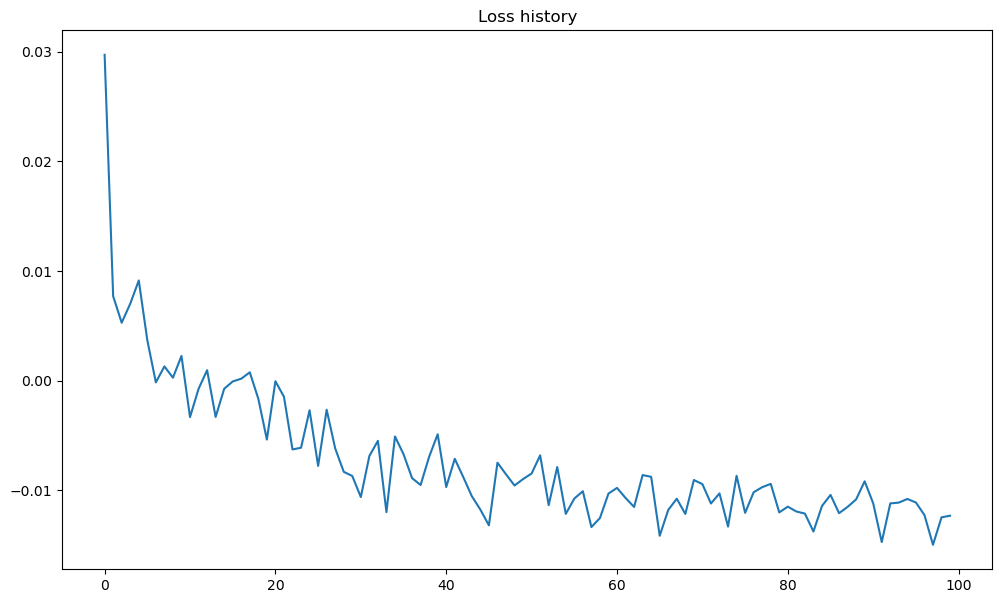

In [763]:
plt.figure(figsize=(12, 7))
plt.plot(loss_hist)
plt.title("Loss history")
plt.show()

# Results

In [764]:
def sample_from_model(model, x_start, n_samples, n_steps=N_STEPS, step_size=STEP_SIZE, sample_noise=SAMPLING_NOISE, decay=1.):
    x = torch.broadcast_to(x_start, (n_samples, 2))
    y = torch.normal(0, 3., size=x.shape, device=DEVICE)
    noise = step_size**2
    for _ in range(n_steps):
        with torch.enable_grad():
            y.requires_grad_(True)
            model_proj = model(y)
            cost = c(y, x_start)
            energy_grad = function_grad(model_proj, y) - function_grad(cost, y)
        
        z = torch.normal(0, sample_noise, size=x.shape, device=DEVICE)
        y = y + 0.5 * step_size * energy_grad / EPS + noise * z
        step_size *= decay
        noise *= decay**0.5
    return y

def visualize_sampling_cond_from_points(model, dataset1, dataset2, n=1, samples=50, swap_colors=False, scale_axis=False, title="Sampling from random points"):
    x_start = dataset1.sample(n)
    y_sampled = sample_from_model(model, x_start, n*samples)

    if SCALED_REGIME:
        x_start = std_scale_inv(x_start, dataset1.mu, dataset1.std)
        y_sampled = std_scale_inv(y_sampled, dataset2.mu, dataset2.std)

    x_start = x_start.cpu().detach().numpy()
    y_sampled = y_sampled.cpu().detach().numpy()

    c1, c2 = ('skyblue', 'orange') if not swap_colors else (
        'orange', 'skyblue')

    ds1_data = dataset1.data
    ds2_data = dataset2.data

    # if SCALED_REGIME:
    #     ds1_data = std_scale(
    #         ds1_data, dataset1.mu, dataset1.std)
    #     ds2_data = std_scale(ds2_data, dataset2.mu, dataset2.std)

    plt.figure(figsize=(8, 8))
    plt.scatter(ds1_data[:, 0].cpu(), ds1_data[:, 1].cpu(),
                c=c1, s=5, marker='o', alpha=0.2)
    plt.scatter(ds2_data[:, 0].cpu(), ds2_data[:, 1].cpu(),
                c=c2, s=5, marker='o', alpha=0.2)

    plt.scatter(x_start[:, 0], x_start[:, 1], c='red', s=20, marker='o', edgecolors='black', linewidths=1.)
    plt.scatter(y_sampled[:, 0], y_sampled[:, 1], c='red',
                s=25, marker='x')

    for i in range(len(y_sampled)):
        plt.plot([x_start[0, 0], y_sampled[i, 0]], [
                 x_start[0, 1], y_sampled[i, 1]], c='red', alpha=0.2)

    if scale_axis:
        # scale plt around sampled points
        x_min = np.min(y_sampled[:, 0])
        x_max = np.max(y_sampled[:, 0])
        y_min = np.min(y_sampled[:, 1])
        y_max = np.max(y_sampled[:, 1])

        plt.xlim(x_min - 0.1*(x_max - x_min), x_max + 0.1*(x_max - x_min))
        plt.ylim(y_min - 0.1*(y_max - y_min), y_max + 0.1*(y_max - y_min))

    plt.title(title)
    plt.show()

## Single point to many projection

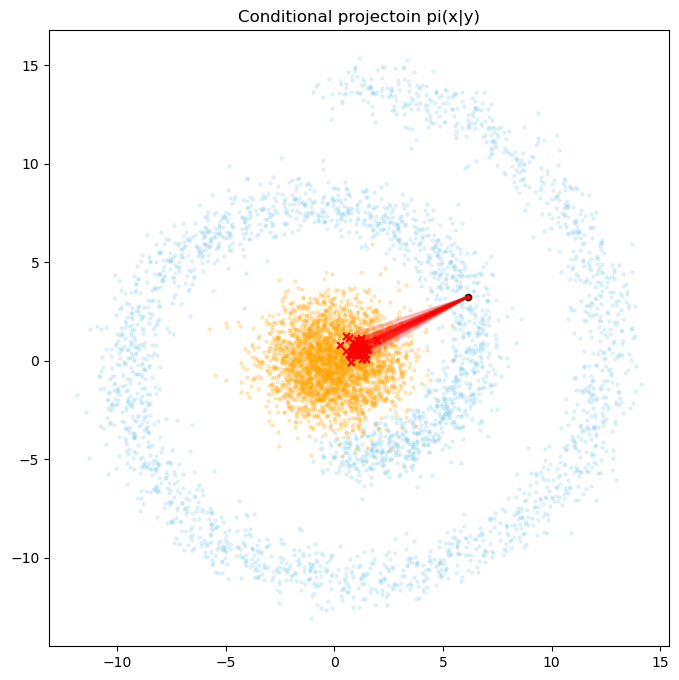

In [771]:
visualize_sampling_cond_from_points(u_model, dataset_y, dataset_x,
                                    title="Conditional projectoin pi(x|y)")

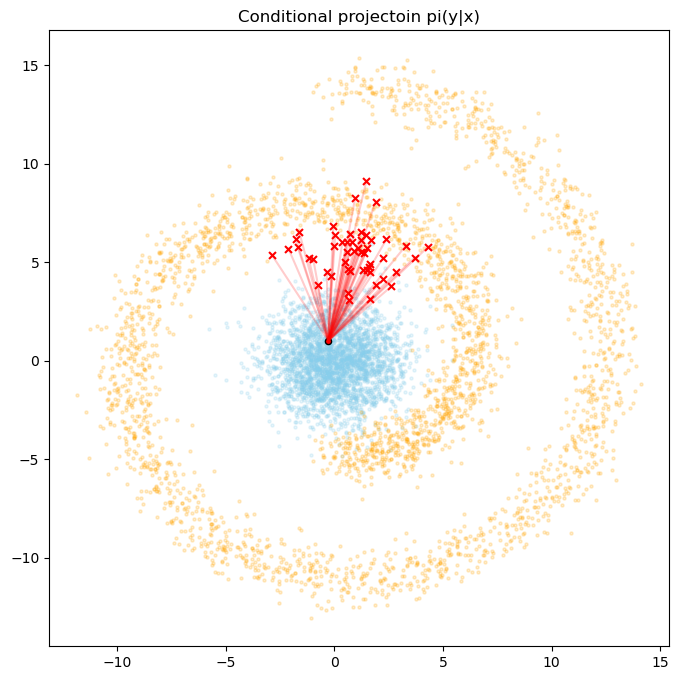

In [783]:
visualize_sampling_cond_from_points(v_model, dataset_x, dataset_y,
                                    title="Conditional projectoin pi(y|x)")

## Projected dataset comparison (1to1 for each point)

In [784]:
def visualize_learned_distribution(model, dataset_from, dataset_to):
    """Visualizes 1-to-1 mapping for each point from source dataset - if everything fine, should closely resemble reference dataset"""
    if SCALED_REGIME:
        ds_x = std_scale(dataset_from.data, dataset_from.mu, dataset_from.std)
        ds_y = std_scale(dataset_to.data, dataset_to.mu, dataset_to.std)
    else:
        ds_x = dataset_from.data
        ds_y = dataset_to.data
    learned_projection = sample_from_model(
        model, ds_x, n_samples=len(dataset_from))
    learned_projection = learned_projection.cpu().detach().numpy()

    _, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].scatter(ds_x[:, 0].cpu(),
                   ds_x[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5)
    axs[0].set_title("Original distribution")
    axs[0].axis('off')

    axs[1].scatter(learned_projection[:, 0], learned_projection[:,
                                                                1], c='red', s=7, marker='o', edgecolors='black', linewidths=0.5)
    axs[1].set_title("Learned projection")
    axs[1].axis('off')

    axs[2].scatter(ds_y[:, 0].cpu(),
                   ds_y[:, 1].cpu(), s=7, marker='o', edgecolors='black', linewidths=0.5, alpha=0.5)
    axs[2].scatter(learned_projection[:, 0], learned_projection[:,
                                                                1], c='red', s=7, marker='o', edgecolors='black', linewidths=0.5, alpha=0.5)
    axs[2].set_title("Reference distribution + Learned Projection")
    axs[2].axis('off')

    plt.show()

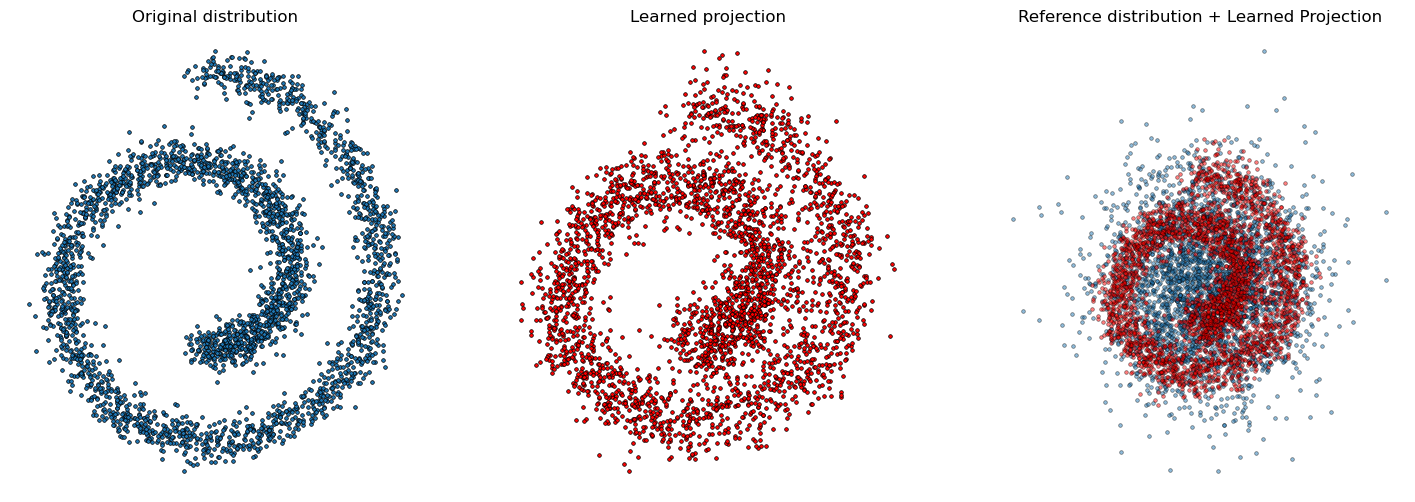

In [785]:
visualize_learned_distribution(u_model, dataset_y, dataset_x)

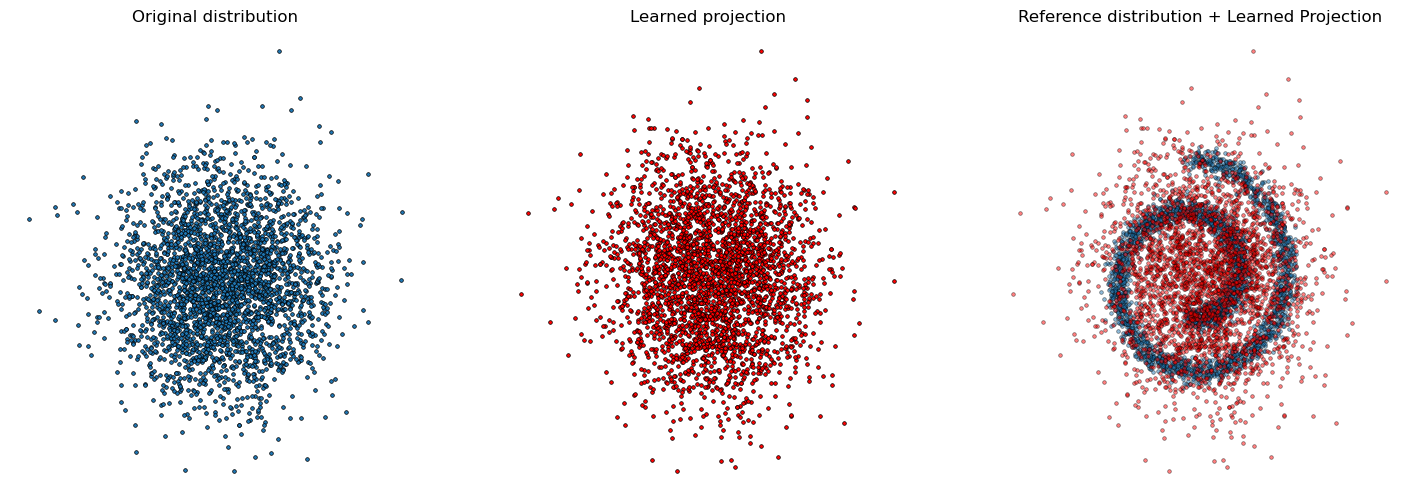

In [786]:
visualize_learned_distribution(v_model, dataset_x, dataset_y)

## Set of random 1 to 1 projections

In [756]:
def visualize_sampling_cond_from_points_1to1(model, dataset1, dataset2, n=1, swap_colors=False, scale_axis=False, title="Sampling from random points"):
    x_start = dataset1.sample(n)
    y_sampled = sample_from_model(model, x_start, n)

    if SCALED_REGIME:
        x_start = std_scale_inv(x_start, dataset1.mu, dataset1.std)
        y_sampled = std_scale_inv(y_sampled, dataset2.mu, dataset2.std)

    x_start = x_start.cpu().detach().numpy()
    y_sampled = y_sampled.cpu().detach().numpy()

    c1, c2 = ('skyblue', 'orange') if not swap_colors else (
        'orange', 'skyblue')

    ds1_data = dataset1.data
    ds2_data = dataset2.data

    # if SCALED_REGIME:
    #     ds1_data = std_scale(
    #         ds1_data, dataset1.mu, dataset1.std)
    #     ds2_data = std_scale(ds2_data, dataset2.mu, dataset2.std)

    plt.figure(figsize=(8, 8))
    plt.scatter(ds1_data[:, 0].cpu(), ds1_data[:, 1].cpu(),
                c=c1, s=5, marker='o', alpha=0.2)
    plt.scatter(ds2_data[:, 0].cpu(), ds2_data[:, 1].cpu(),
                c=c2, s=5, marker='o', alpha=0.2)

    plt.scatter(x_start[:, 0], x_start[:, 1], c='red', s=20,
                marker='o', edgecolors='black', linewidths=1.)
    plt.scatter(y_sampled[:, 0], y_sampled[:, 1], c='red',
                s=25, marker='x')

    for i in range(len(y_sampled)):
        plt.plot([x_start[i, 0], y_sampled[i, 0]], [
                 x_start[i, 1], y_sampled[i, 1]], c='red', alpha=0.2)

    if scale_axis:
        # scale plt around sampled points
        x_min = np.min(y_sampled[:, 0])
        x_max = np.max(y_sampled[:, 0])
        y_min = np.min(y_sampled[:, 1])
        y_max = np.max(y_sampled[:, 1])

        plt.xlim(x_min - 0.1*(x_max - x_min), x_max + 0.1*(x_max - x_min))
        plt.ylim(y_min - 0.1*(y_max - y_min), y_max + 0.1*(y_max - y_min))

    plt.title(title)
    plt.show()

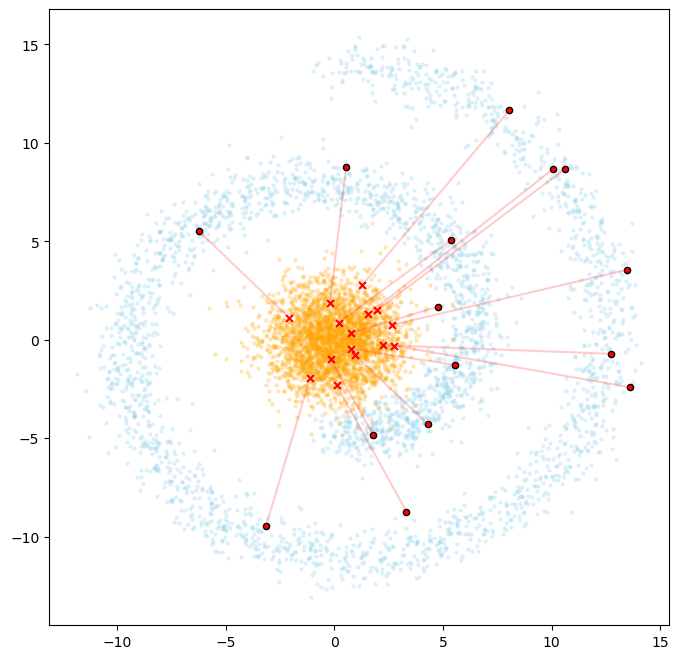

In [787]:
visualize_sampling_cond_from_points_1to1(u_model, dataset_y, dataset_x, n=15,
                                    swap_colors=False, scale_axis=False, title="")

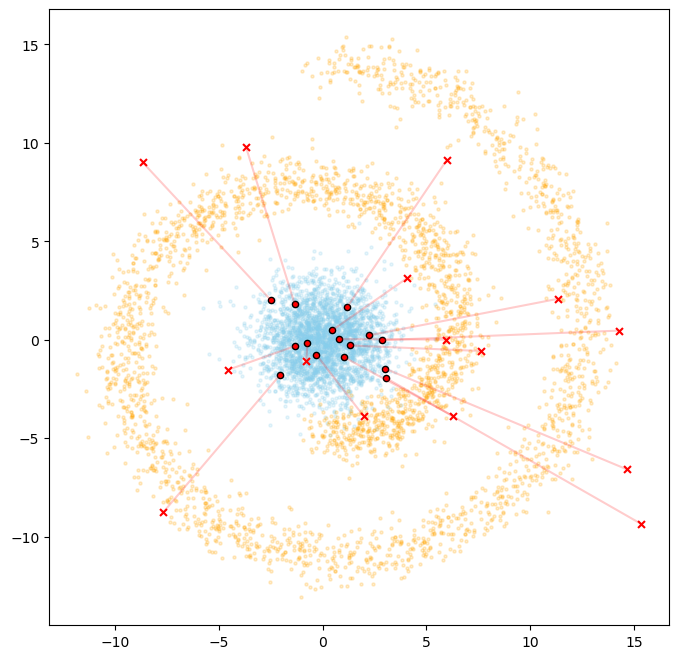

In [758]:
visualize_sampling_cond_from_points_1to1(v_model, dataset_x, dataset_y, n=15,
                                         swap_colors=False, scale_axis=False, title="")